<a href="https://colab.research.google.com/github/naenumtou/dataScienceLab/blob/main/basicCLV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Set auto reload
%reload_ext autoreload
%autoreload 2

In [ ]:
# Install lifetimes library
!pip install Lifetimes

In [ ]:
# Change directory to Google Drive
%cd /content/drive/My Drive/Colab Notebooks/onlineRetail

/content/drive/My Drive/Colab Notebooks/onlineRetail


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix, plot_period_transactions

# Config 
%config InlineBackend.figure_format = 'retina' #Retina display
plt.style.use('seaborn-deep') #Plot style

In [ ]:
# Import data
df = pd.read_csv(
    'onlineRetailClean.csv',
    dtype = {
        'Invoice': str,
        'StockCode': str,
        'Description': str,
        'Quantity': np.float64,
        'Price': np.float64,
        'Customer ID': str,
        'Country': str,
        'TotalPrice': np.float64
    },
    parse_dates = ['InvoiceDate']
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805549 entries, 0 to 805548
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      805549 non-null  object        
 1   StockCode    805549 non-null  object        
 2   Description  805549 non-null  object        
 3   Quantity     805549 non-null  float64       
 4   InvoiceDate  805549 non-null  datetime64[ns]
 5   Price        805549 non-null  float64       
 6   Customer ID  805549 non-null  object        
 7   Country      805549 non-null  object        
 8   TotalPrice   805549 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 55.3+ MB


In [ ]:
# Extract year, month and day from 'InvoiceDate'
df['InvoiceMonthly'] = df['InvoiceDate'].dt.to_period('M').dt.to_timestamp('M') #Convert back to 'datetime64[ns]'
df['InvoiceDaily'] = df['InvoiceDate'].dt.to_period('D').dt.to_timestamp('D') #Convert back to 'datetime64[ns]'
df.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,InvoiceMonthly,InvoiceDaily
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0,2018-12-01 07:45:00,6.95,13085,United Kingdom,83.4,2018-12-31,2018-12-01
1,489434,79323P,PINK CHERRY LIGHTS,12.0,2018-12-01 07:45:00,6.75,13085,United Kingdom,81.0,2018-12-31,2018-12-01
2,489434,79323W,WHITE CHERRY LIGHTS,12.0,2018-12-01 07:45:00,6.75,13085,United Kingdom,81.0,2018-12-31,2018-12-01
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.0,2018-12-01 07:45:00,2.10,13085,United Kingdom,100.8,2018-12-31,2018-12-01
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0,2018-12-01 07:45:00,1.25,13085,United Kingdom,30.0,2018-12-31,2018-12-01


In [ ]:
# Remove testing product
df = df[~df['StockCode'].isin(['TEST001', 'TEST002'])]

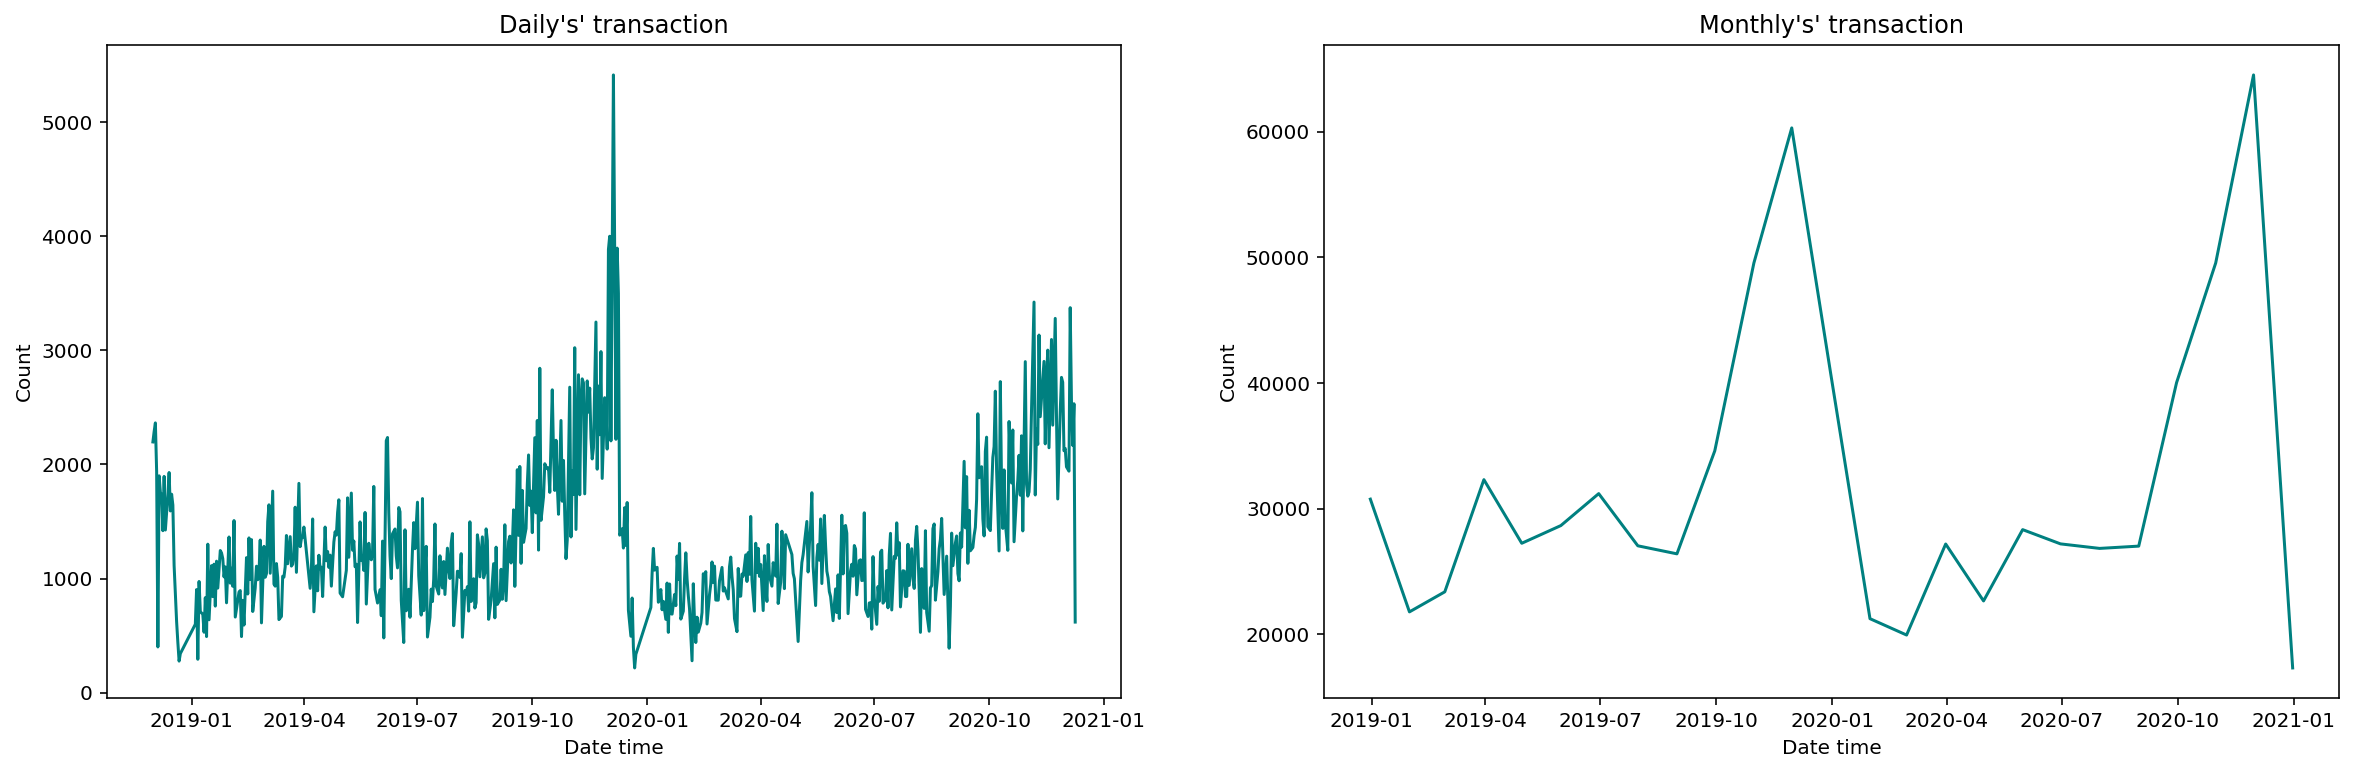

In [ ]:
# Plot invoice transaction
plt.figure(figsize = (20, 6))
for i, col in enumerate(['Daily', 'Monthly']):
  dataPlot = df.groupby(
      [f'Invoice{col}']
  )['Invoice'].count()
  plt.subplot(1, 2, i + 1)
  plt.plot(
      dataPlot.index,
      dataPlot,
      c = 'teal'
  ),
  plt.title(f"{col}'s' transaction")
  plt.xlabel('Date time')
  plt.ylabel('Count')
plt.show()

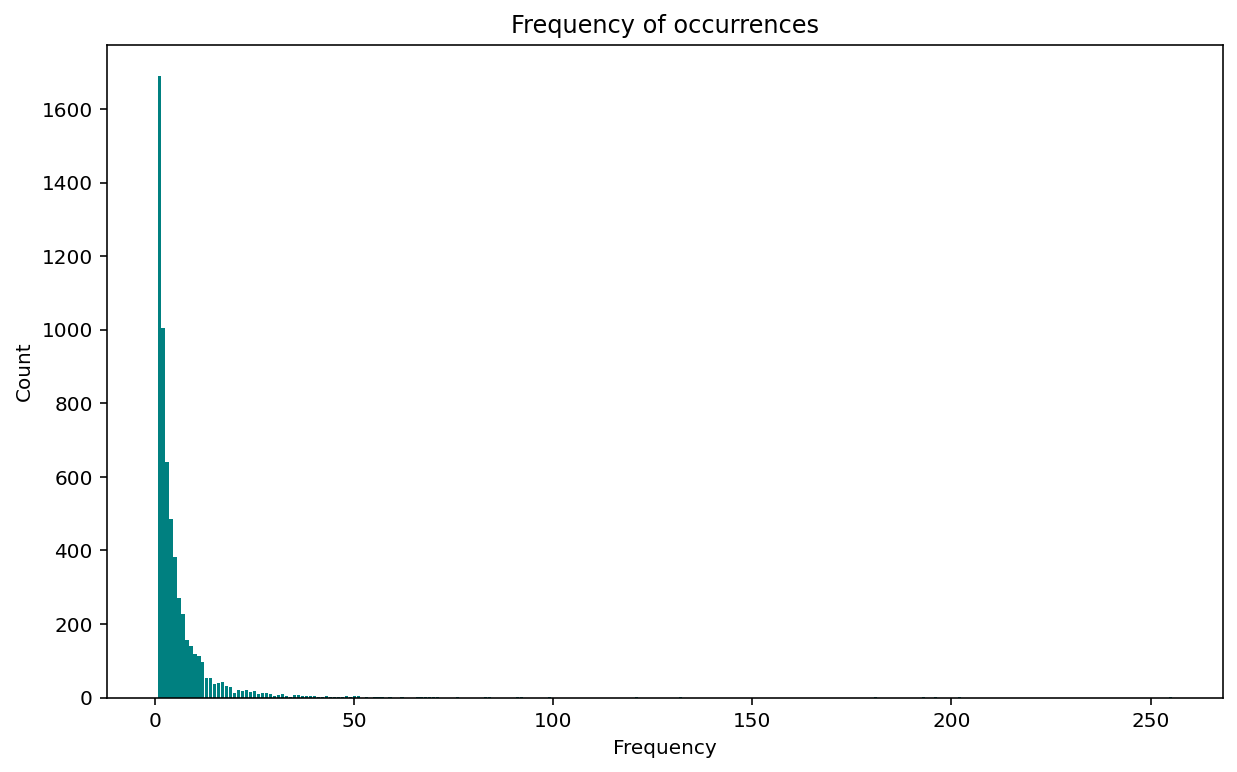

In [ ]:
# Frequency of occurrences
'''
Frequency of occurrences
This means total purchases per customer in a given time basis.
For example, how many times that customer purchase only 1 day in daliy basis.
'''

# Plot
plt.figure(figsize = (10, 6))
plt.bar(
    df.groupby(['Customer ID'])['InvoiceDaily'].nunique().value_counts().index,
    df.groupby(['Customer ID'])['InvoiceDaily'].nunique().value_counts(),
    color = 'teal'
)
plt.title('Frequency of occurrences')
plt.xlabel('Frequency')
plt.ylabel('Count')
plt.show()

In [ ]:
# Data for model
endDate = df['InvoiceDate'].max() #End of transaction

# Manual create RFM Parameters
dfModel = df.groupby(['Customer ID']).agg(
    {
        'InvoiceDaily': lambda date: date.nunique(),
        'InvoiceDate': [
                        lambda date: round((date.max() - date.min()) / np.timedelta64(1, 'D')),
                        lambda date: round((endDate - date.min()) / np.timedelta64(1, 'D'))
        ],
        'TotalPrice': lambda price: price.sum()
    }
)

dfModel.columns = dfModel.columns.droplevel(0)
dfModel.columns = ['frequency', 'recency', 'T', 'TotalPrice']
dfModel = dfModel.eval(
    "monetary_value = TotalPrice / frequency"
).drop(
    ['TotalPrice'],
     axis = 1
) #Value per transaction
dfModel.head(5)

,frequency,recency,T,monetary_value
Customer ID,,,,
12346,3,322,648,166.866667
12347,8,403,405,704.165000
12348,5,364,439,398.372000
12349,4,572,590,946.625000
12350,1,0,311,331.340000


In [ ]:
# Using function from lifetimes library (Faster)
dfModel = summary_data_from_transaction_data(
    df,
    customer_id_col = 'Customer ID',
    datetime_col = 'InvoiceDate',
    monetary_value_col = 'TotalPrice',
    observation_period_end = endDate,
    freq = 'D',
    include_first_transaction = True
)
dfModel.head(5)

,frequency,recency,T,monetary_value
Customer ID,,,,
12346,3.0,322.0,648.0,166.866667
12347,8.0,403.0,405.0,704.165000
12348,5.0,364.0,439.0,398.372000
12349,4.0,572.0,590.0,946.625000
12350,1.0,0.0,311.0,331.340000


In [ ]:
# Describe variable
dfModel.describe().T

,count,mean,std,min,25%,50%,75%,max
frequency,5878.0,5.631337,9.999831,1.000000,1.0000,3.00000,6.000000,255.000
recency,5878.0,273.835488,259.391463,0.000000,0.0000,221.50000,513.000000,739.000
T,5878.0,475.019054,223.429917,0.000000,314.0000,531.00000,669.000000,739.000
monetary_value,5878.0,383.587085,429.888786,2.816667,186.2575,298.58125,438.645357,9195.225


In [ ]:
# Select 'frequency' more than 1
dfModel = dfModel[dfModel['frequency'] > 1]

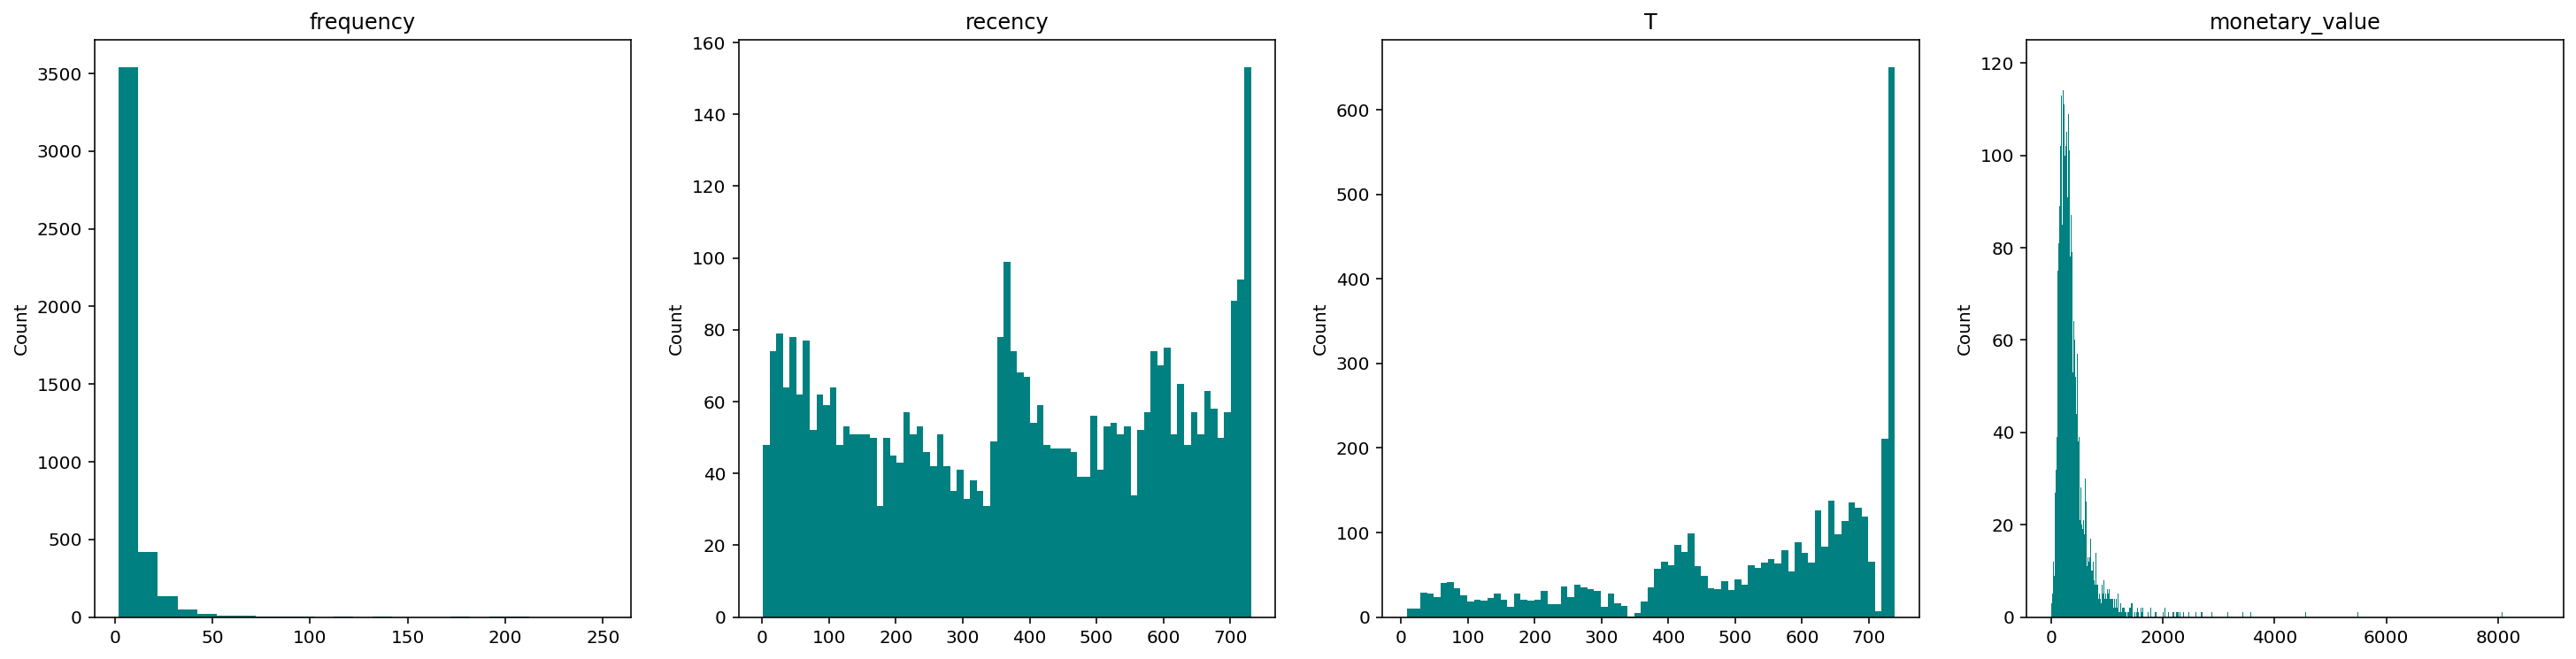

In [ ]:
# Plot
plt.figure(figsize = (25, 6))
for i, var in enumerate(dfModel.columns):
  dataPlot = dfModel[var]
  bins = np.arange(
      dataPlot.min(),
      dataPlot.max() + 1,
      10
  )
  plt.subplot(1, len(dfModel.columns), i + 1)
  plt.hist(
      dataPlot,
      bins = bins,
      color = 'teal'
  )
  plt.title(f'{var}')
  plt.ylabel('Count')
plt.show()

In [ ]:
# BG/NBD Model (Beta-Geometric / Negative Binomial Distribution)
BGFModel = BetaGeoFitter()

# Fitting
BGFModel.fit(
    dfModel['frequency'],
    dfModel['recency'],
    dfModel['T']
)

<lifetimes.BetaGeoFitter: fitted with 4189 subjects, a: 0.37, alpha: 112.00, b: 6.36, r: 2.08>

In [ ]:
# Summary BGF Model
BGFModel.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,2.082793,0.058047,1.969021,2.196565
alpha,111.998071,3.598953,104.944122,119.052019
a,0.371962,0.035134,0.303099,0.440825
b,6.357185,0.748625,4.889880,7.824490


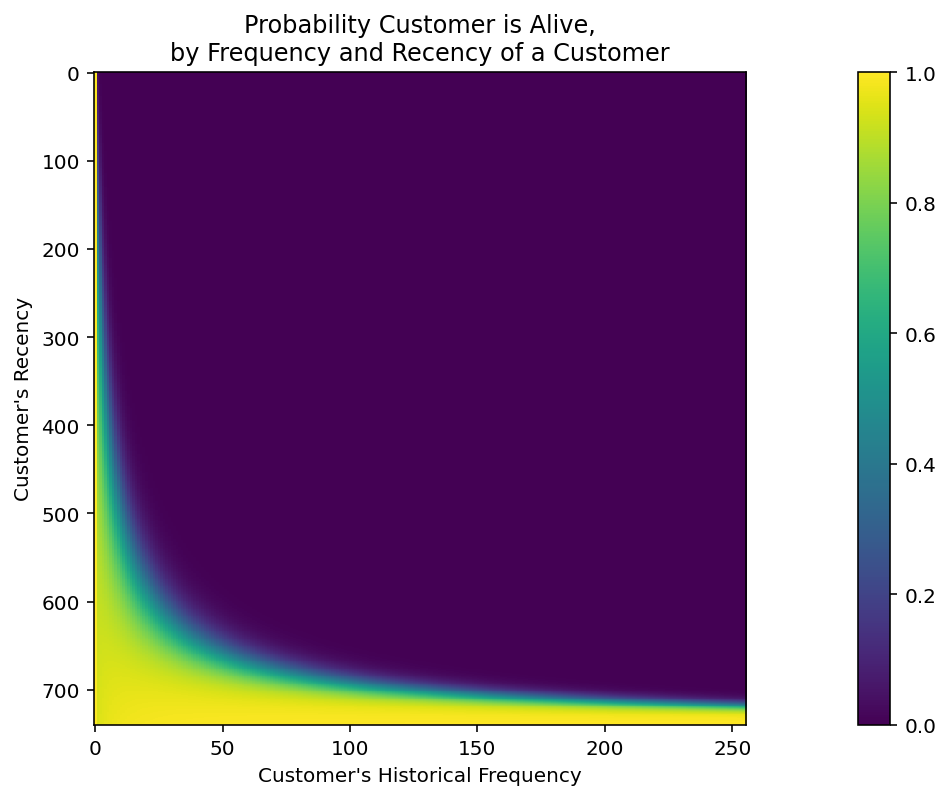

In [ ]:
# Plot customer's probability of being alive
plt.figure(figsize = (20, 6))
plot_probability_alive_matrix(BGFModel)
plt.show()

### The probability of a customer of being alive
- If a customer has a high number of transactions ***(high frequency)*** and the time between first and last transaction is hight ***(high recency)***, the probability of still being alive is **high**. (bottom right: yellow color)
- On the other hand, if a customer has a low number of transactions ***(low frequency)*** but the time between first and last transaction is low ***(low recency)***, the probability of still being alive is also **high**. (top left: yellow color). This could be the reason that these customers are new and just enter to the transaction.

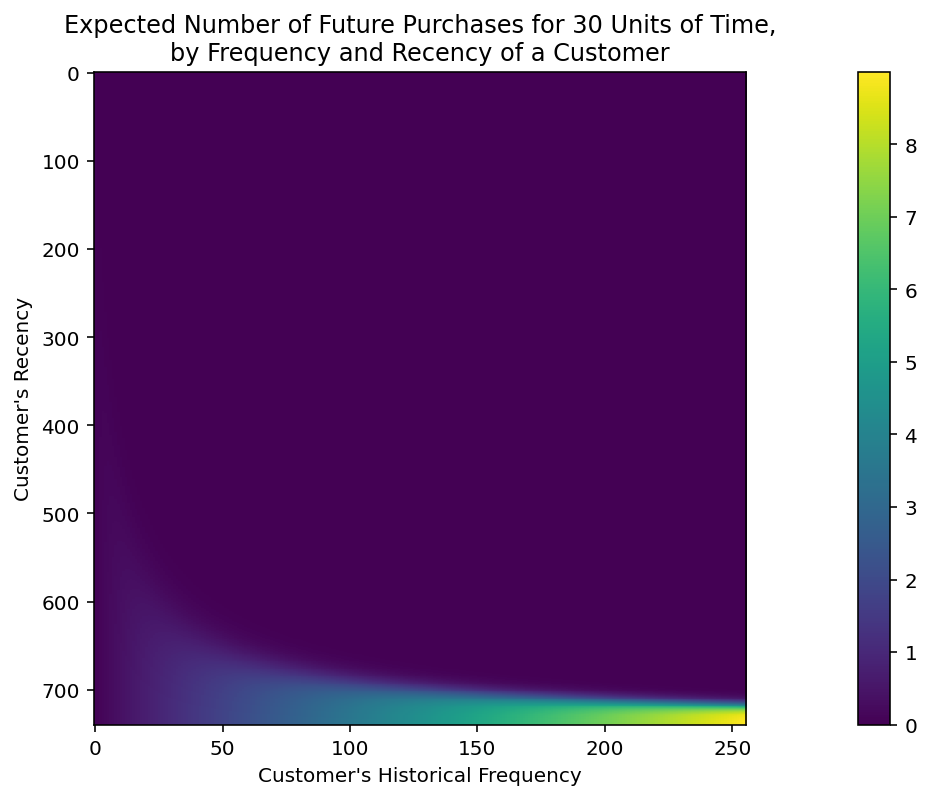

In [ ]:
# Plot customer's expected number of future puchases
plt.figure(figsize = (20, 6))
plot_frequency_recency_matrix(
    BGFModel,
    T = 30 #Predict for the next 30 days
)
plt.show()

### Expected future number of purchases
- If the customer has made about 250+ transactions and the latest purchase were 700 days old, it is considered as the best customers and will be more likely to buy in the following 30 days. (bottom right: yellow color)

In [ ]:
# Predict the expected number of repeat purchases on each customer
t = 30 #The next 30 days

dfModel['Predicted_purchases30'] = BGFModel.conditional_expected_number_of_purchases_up_to_time(
    t,
    dfModel['frequency'],
    dfModel['recency'],
    dfModel['T']
)

# Show table
dfModel.sort_values(
    by = ['frequency'],
    ascending = False
).head(5)

,frequency,recency,T,monetary_value,Predicted_purchases30
Customer ID,,,,,
14911,255.0,738.0,739.0,1107.218588,8.987818
12748,202.0,736.0,736.0,261.062475,7.161134
15311,196.0,739.0,739.0,595.143444,6.925902
17841,193.0,737.0,738.0,366.682435,6.825506
14606,181.0,736.0,737.0,169.922265,6.412448


In [ ]:
# Estimates the probability of being alive on each customer
dfModel['p_alive'] = BGFModel.conditional_probability_alive(
    dfModel['frequency'],
    dfModel['recency'],
    dfModel['T']
)

# Show table
dfModel.sort_values(
    by = ['frequency'],
    ascending = False
).head(5)

,frequency,recency,T,monetary_value,Predicted_purchases30,p_alive
Customer ID,,,,,,
14911,255.0,738.0,739.0,1107.218588,8.987818,0.998071
12748,202.0,736.0,736.0,261.062475,7.161134,0.998209
15311,196.0,739.0,739.0,595.143444,6.925902,0.998156
17841,193.0,737.0,738.0,366.682435,6.825506,0.997646
14606,181.0,736.0,737.0,169.922265,6.412448,0.997529


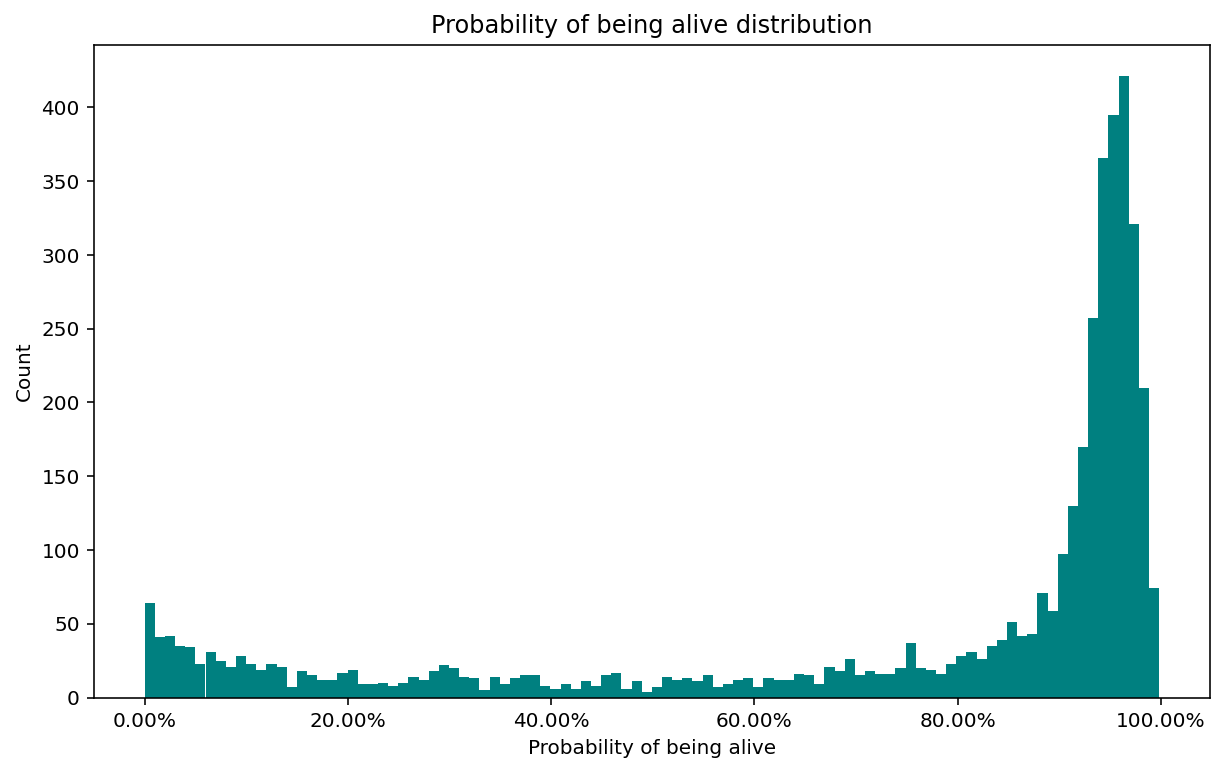

In [ ]:
# Plot probability of being alive
plt.figure(figsize = (10, 6))
plt.hist(
    dfModel['p_alive'],
    bins = 100,
    color = 'teal'
)
plt.gca().set_xticklabels([f'{x * 100:.2f}%' for x in plt.gca().get_xticks()])
plt.title('Probability of being alive distribution')
plt.xlabel('Probability of being alive')
plt.ylabel('Count')
plt.show()

In [ ]:
# Gamma-Gamma model for estimating values
GGFModel = GammaGammaFitter()

GGFModel.fit(
    frequency = dfModel['frequency'],
    monetary_value = dfModel['monetary_value']
)

<lifetimes.GammaGammaFitter: fitted with 4189 subjects, p: 1.86, q: 3.94, v: 634.97>

In [ ]:
# Expected average profit
dfModel['Average_profit'] = GGFModel.conditional_expected_average_profit(
    dfModel['frequency'],
    dfModel['monetary_value']
)

# Show table
dfModel.sort_values(
    by = ['frequency'],
    ascending = False
).head(5)

,frequency,recency,T,monetary_value,Predicted_purchases30,p_alive,Average_profit
Customer ID,,,,,,,
14911,255.0,738.0,739.0,1107.218588,8.987818,0.998071,1102.892680
12748,202.0,736.0,736.0,261.062475,7.161134,0.998209,262.160603
15311,196.0,739.0,739.0,595.143444,6.925902,0.998156,593.610194
17841,193.0,737.0,738.0,366.682435,6.825506,0.997646,366.975912
14606,181.0,736.0,737.0,169.922265,6.412448,0.997529,171.933386


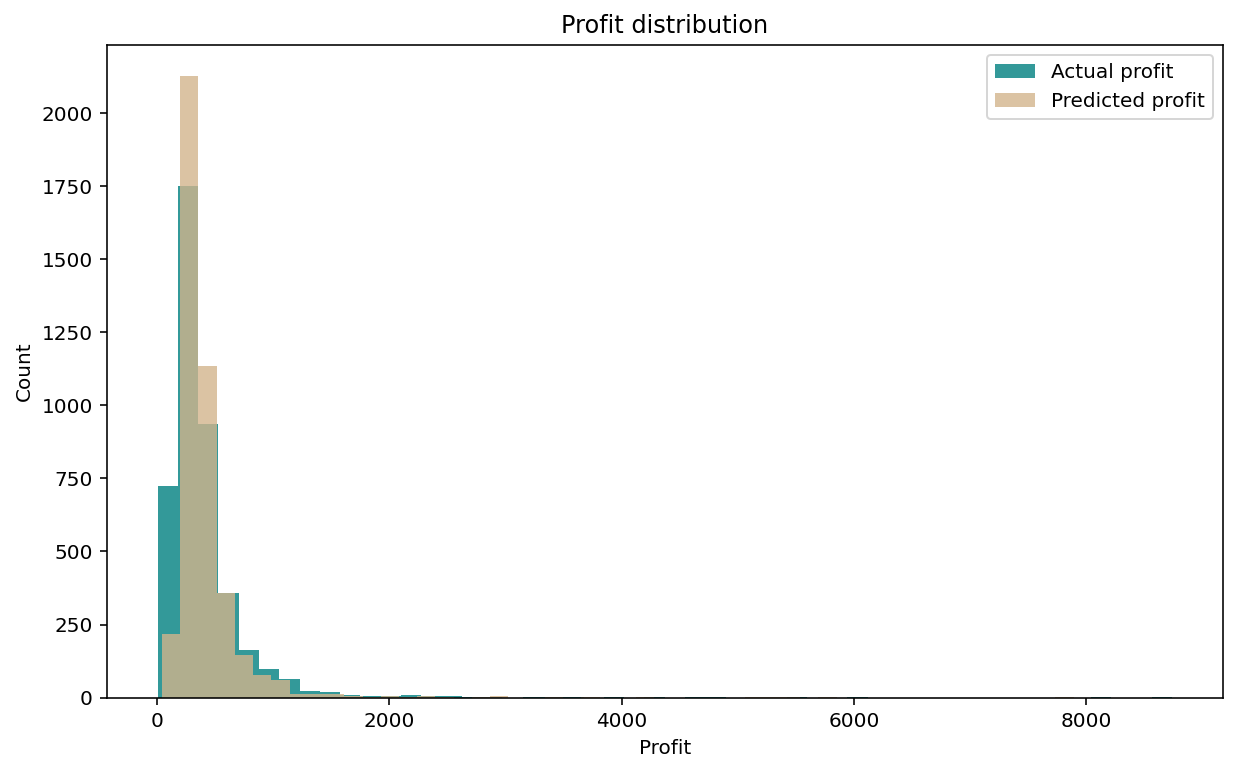

In [ ]:
# Plot
plt.figure(figsize = (10, 6))
plt.hist(
    dfModel['monetary_value'],
    bins = 50,
    alpha = 0.8,
    label = 'Actual profit',
    color = 'teal'
)
plt.hist(
    dfModel['Average_profit'],
    bins = 50,
    alpha = 0.8,
    label = 'Predicted profit',
    color = 'tan'
)
plt.title('Profit distribution')
plt.xlabel('Profit')
plt.ylabel('Count')
plt.legend(frameon = True, facecolor = 'white')
plt.show()

In [ ]:
# Customer Lifetime Value (CLV)
dfModel['CLV30'] = GGFModel.customer_lifetime_value(
    BGFModel,
    dfModel['frequency'],
    dfModel['recency'],
    dfModel['T'],
    dfModel['monetary_value'],
    time = 1, #In 'month' unit
    freq = 'D', #In a basis of 'T'
    discount_rate = 0.01
)

# Show table
dfModel.sort_values(
    by = ['frequency'],
    ascending = False
).head(5)

,frequency,recency,T,monetary_value,Predicted_purchases30,p_alive,Average_profit,CLV30
Customer ID,,,,,,,,
14911,255.0,738.0,739.0,1107.218588,8.987818,0.998071,1102.892680,9814.453783
12748,202.0,736.0,736.0,261.062475,7.161134,0.998209,262.160603,1858.779397
15311,196.0,739.0,739.0,595.143444,6.925902,0.998156,593.610194,4070.580444
17841,193.0,737.0,738.0,366.682435,6.825506,0.997646,366.975912,2479.996320
14606,181.0,736.0,737.0,169.922265,6.412448,0.997529,171.933386,1091.597917


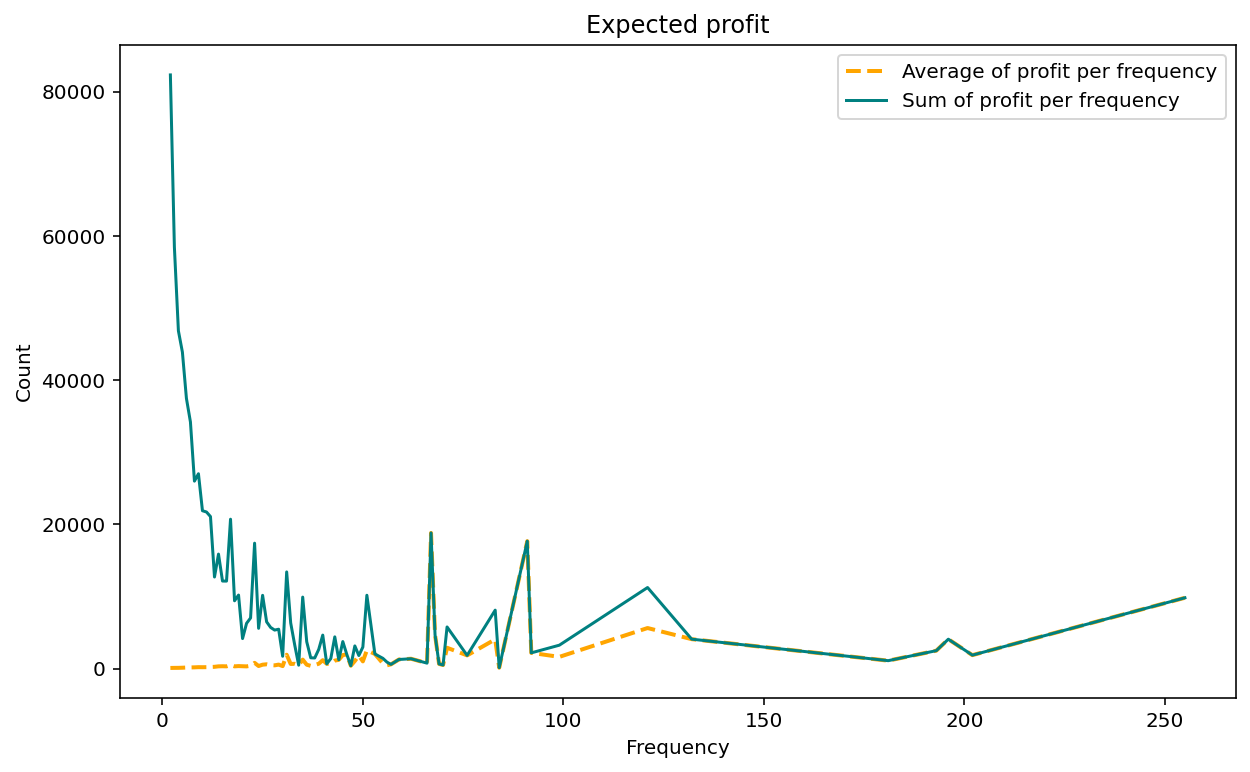

In [ ]:
# Plot
plt.figure(figsize = (10, 6))
plt.plot(
    dfModel.groupby(['frequency'])['CLV30'].mean(),
    linestyle = '--',
    linewidth = 2,
    color = 'orange',
    label = 'Average of profit per frequency'
)
plt.plot(
    dfModel.groupby(['frequency'])['CLV30'].sum(),
    color = 'teal',
    label = 'Sum of profit per frequency'
)
plt.title('Expected profit')
plt.xlabel('Frequency')
plt.ylabel('Count')
plt.legend(frameon = True, facecolor = 'white')
plt.show()